## Загружаем необходимые библиотеки

In [1]:
import os

import random
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px

import yaml
import torch
import json
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split

Загрузка YOLO5

In [2]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16078, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16078 (delta 6), reused 9 (delta 1), pack-reused 16056
Receiving objects: 100% (16078/16078), 14.70 MiB | 9.64 MiB/s, done.
Resolving deltas: 100% (11034/11034), done.
/content/yolov5


In [3]:
%cd /content/yolov5

!pip install -qr requirements.txt
!pip install -q roboflow

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.6/646.6 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.0 

## Загрузка датасета

Также посмотрим количество изображений в датасете и часть из них визуализируем





In [4]:
!git clone 'https://github.com/MelnikDM/Construction.git'

Cloning into 'Construction'...
remote: Enumerating objects: 19277, done.
remote: Counting objects: 100% (5717/5717), done.
remote: Compressing objects: 100% (2875/2875), done.
remote: Total 19277 (delta 2842), reused 5715 (delta 2840), pack-reused 13560
Receiving objects: 100% (19277/19277), 1.06 GiB | 30.50 MiB/s, done.
Resolving deltas: 100% (9769/9769), done.


In [5]:
images_path = '/content/yolov5/Construction/HardHat_2/data/Images'

In [6]:
images_count = np.array(os.listdir('/content/yolov5/Construction/HardHat_2/data/Images'))
print(f'Количество изображений в датасете: {images_count.shape[0]}')

Количество изображений в датасете: 2169


In [7]:
def display_multiple_img(images: np.ndarray, images_path: str, cols: int = 2):

    """ Функция для визуализации фотографий """

    assert (images.shape[0] % cols) == 0

    for imagename_pair in images.reshape(-1, cols):
        _, axs = plt.subplots(nrows = 1, ncols = cols, figsize = (10, 10))

        for ind, imagename in enumerate(imagename_pair):
            image = cv2.imread(
                os.path.join(images_path, imagename)
            )
            axs[ind].imshow(image[:,:,::-1])
            axs[ind].axis('off')

In [8]:
images_indices = np.arange(images_count.shape[0], dtype='int')
np.random.shuffle(images_indices)

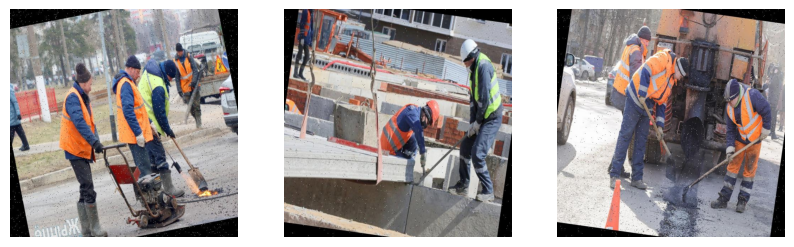

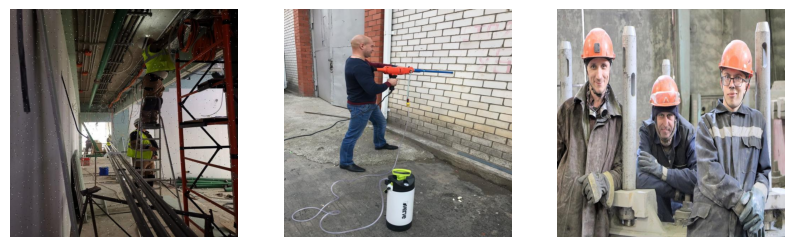

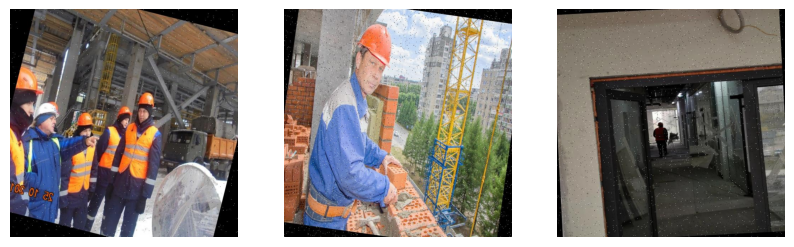

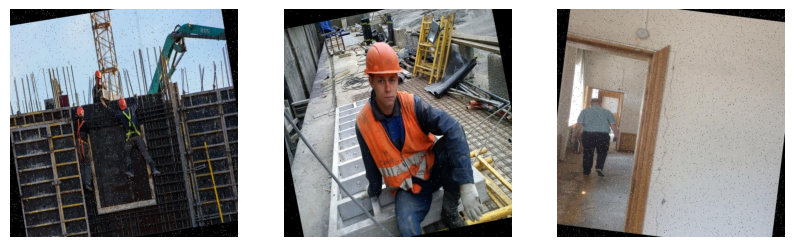

In [9]:
k = 12
first_k_images = images_count[images_indices][:k]

display_multiple_img(
    images=first_k_images,
    images_path=images_path,
    cols=3
)

In [10]:
# Размеры изображений изменены на 640х640 => aspect ratio будет равен 1.

# def get_images_metainfo(images_list: np.ndarray, images_path: str):

#     """
#        Данная функция собирает метаданные изображения
#        Результат функции это список словарей: imagename,
#        width, height, aspect_ratio
#     """

#     metainfo = []

#     for imagename in tqdm(images_list, total = images_list.shape[0]):
#         current_meta = {
#             'imagename': imagename,
#         }

#         image_path = os.path.join(images_path, imagename)
#         width, height, channels = cv2.imread(image_path).shape

#         current_meta['width'] = width
#         current_meta['height'] = height
#         current_meta['aspect_ratio'] = width/height
#         metainfo.append(current_meta)

#     return metainfo

In [11]:
input_folder = r"/content/yolov5/Construction/HardHat_2/data/Annotations"

# cols = ['name', 'xmin', 'ymin', 'xmax', 'ymax']

def merge_files(input_folder):
    global df2
    xml_list = []
    for file in os.listdir(input_folder):
        df = pd.read_xml(f"{input_folder}/{file}", iterparse={"object": ["name", "xmin", "ymin", "xmax", "ymax"]})
        xml_list.append(df)

    pd.set_option('display.max_columns', None)
    xml_merged = pd.concat(xml_list, ignore_index=True)
    df2 = pd.DataFrame(xml_merged)
    return df2


merge_files(input_folder)

,name,xmin,xmax,ymin,ymax
0,NoHelmet,342,356,107,117
1,Jacket,326,359,117,155
2,Helmet,346,360,157,169
3,Helmet,346,367,264,300
4,Helmet,234,277,245,300
...,...,...,...,...,...
14765,Jacket,420,426,149,160
14766,Jacket,437,443,147,156
14767,Jacket,509,515,142,154
14768,NoJacket,514,520,141,153


In [12]:
input_folder = r"/content/yolov5/Construction/HardHat_2/data/Annotations"


def merge_files(input_folder):
    global df2
    xml_list = []
    for file in os.listdir(input_folder):
        df = pd.read_xml(f"{input_folder}/{file}", iterparse={"object": ["name"]})
        xml_list.append(df)

    pd.set_option('display.max_columns', None)
    xml_merged = pd.concat(xml_list, ignore_index=True)
    df2 = pd.DataFrame(xml_merged)
    return df2


merge_files(input_folder)

,name
0,NoHelmet
1,Jacket
2,Helmet
3,Helmet
4,Helmet
...,...
14765,Jacket
14766,Jacket
14767,Jacket
14768,NoJacket


In [13]:
df2.name.value_counts()

Helmet      5509
Jacket      4105
NoJacket    2760
NoHelmet    2396
Name: name, dtype: int64

In [14]:
fig = px.bar(df2.name.value_counts().sort_index(),
             color=df2.name.value_counts().sort_index().index, opacity=0.85,
             log_y=True,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class</b>",)
fig.update_layout(legend_title=None,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>")

fig.show()

## Обработка аннотаций

И разбиение выборок на обучающую, валидационную и тестовую





In [15]:
classes = {'Helmet':0,'NoHelmet':1, 'NoJacket':2, 'Jacket':3}

In [16]:
!mkdir '/content/yolov5/labels'

In [17]:
for name in os.listdir('/content/yolov5/Construction/HardHat_2/data/Annotations'):
  with open('/content/yolov5/Construction/HardHat_2/data/Annotations/'+name, 'r') as file:
    xml_file = file.read()
    soup = BeautifulSoup(xml_file, 'xml')
    size = soup.find("size")
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    for tag in soup.findAll("object"):
      cls = tag.find("name").text
      xmin = int(tag.find("xmin").text)
      ymin = int(tag.find("ymin").text)
      xmax = int(tag.find("xmax").text)
      ymax = int(tag.find("ymax").text)

      w = xmax - xmin #вычисляем ширину бокса
      h = ymax - ymin #вычисляем высоту бокса
      x = xmin + (w / 2) #находим центр бокса по ширине
      y = ymin + (h / 2) #находим центр бокса по высоте

      #нормируем значения
      x = x / width
      w = w / width
      y = y / height
      h = h / height

      #записываем в файл
      with open('/content/yolov5/labels/'+name[:-3]+'txt', 'a') as f:
        f.write('{} {} {} {} {}\n'.format(classes[cls], x, y, w, h))

In [18]:
image_list = os.listdir('/content/yolov5/Construction/HardHat_2/data/Images')
train_list, test_list = train_test_split(image_list, test_size=0.2)
val_list, test_list = train_test_split(test_list, test_size=0.5)

print('Обучающая выборка: ',len(train_list))
print('Проверочная выборка: ',len(val_list))
print('Тестовая выборка:' ,len(test_list))

Обучающая выборка:  1735
Проверочная выборка:  217
Тестовая выборка: 217


In [19]:
!mkdir '/content/yolov5/images/'
!mkdir '/content/yolov5/images/'
!mkdir '/content/yolov5/images/train/'
!mkdir '/content/yolov5/images/valid/'

mkdir: cannot create directory ‘/content/yolov5/images/’: File exists


In [20]:
# !mkdir '/content/train/'
# !mkdir '/content/valid/'
# !mkdir '/content/train/images/'
# !mkdir '/content/valid/images'
# !mkdir '/content/train/labels'
# !mkdir '/content/valid/labels'

In [21]:
!mkdir '/content/yolov5/labels/train/'
!mkdir '/content/yolov5/labels/valid/'

In [22]:
def move_data(name_list, folder, newfolder, mode, img=True):
  """
  Функция перемещает файлы в указанную папку.
  name_list - список с названиями файлов для перемещения
  folder    - путь к папке откуда берем файл
  mode      - название папки куда перемещаем
  img       - указывает какой тип файла мы перемещаем
  """
  format = 'jpg' if img==True else 'txt'
  for name in name_list:
    name = name[:-3]+format
    # shutil.move(folder + name, folder + '{}/'.format(mode) + name)
    shutil.move(folder + name, newfolder + '{}/'.format(mode) + name)

In [23]:
move_data(train_list, '/content/yolov5/Construction/HardHat_2/data/Images/', '/content/yolov5/images/', 'train', img=True)
move_data(val_list, '/content/yolov5/Construction/HardHat_2/data/Images/', '/content/yolov5/images/', 'valid', img=True)

In [24]:
move_data(train_list, '/content/yolov5/labels/', '/content/yolov5/labels/', 'train', img=False)
move_data(val_list, '/content/yolov5/labels/', '/content/yolov5/labels/', 'valid', img=False)

## Загрузка и обучение модели Yolo_v5

In [25]:
yaml_file = {'train':'/content/yolov5/images/train',
             'val': '/content/yolov5/images/valid',
             'nc' : '4',
             'names' : ['Helmet', 'NoHelmet', 'NoJacket', 'Jacket']}

with open('helmet.yaml', 'w') as file:
    documents = yaml.dump(yaml_file, file)

In [26]:
!python train.py --img 640 --batch 32 --epochs 64 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt

2023-12-02 13:12:01.366217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 13:12:01.366287: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 13:12:01.366334: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=64, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD,

In [33]:
from PIL import Image
from matplotlib import pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

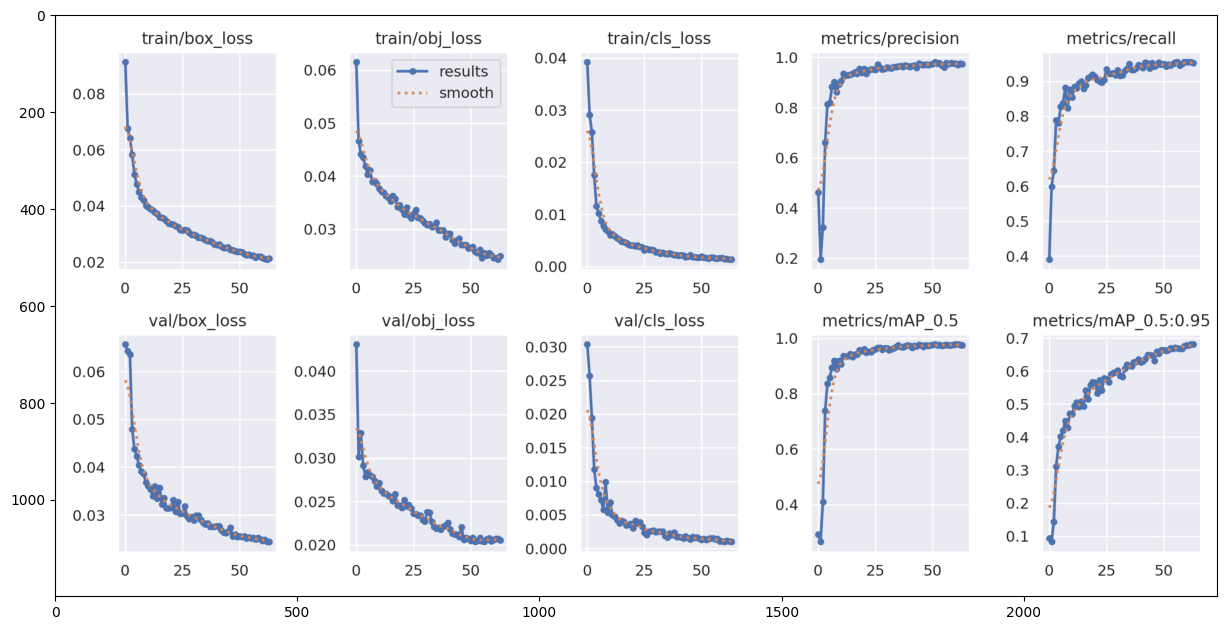

In [34]:
img = Image.open('/content/yolov5/runs/train/exp/results.png')
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show

## Проверка на тестовой выборке

In [35]:
!mkdir '/content/yolov5/images/test/'
move_data(test_list, '/content/yolov5/Construction/HardHat_2/data/Images/', '/content/yolov5/images/', 'test', img=True)

mkdir: cannot create directory ‘/content/yolov5/images/test/’: File exists


FileNotFoundError: ignored

In [36]:
!python detect.py --img 640 --source /content/yolov5/images/test/  --weights /content/yolov5/runs/train/exp/weights/best.pt --conf 0.25

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/yolov5/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20865057 parameters, 0 gradients, 47.9 GFLOPs
image 1/217 /content/yolov5/images/test/HardHat0329_jpg.rf.ff99f403d6b00b8af85c116d051cabe8.jpg: 640x640 2 Helmets, 1 NoHelmet, 1 NoJacket, 2 Jackets, 27.0ms
image 2/217 /content/yolov5/images/test/HardHat0331_jpg.rf.ee73d91c3bccbf832125f73b63ad23d8.jpg: 640x640 2 Helmets, 2 Jackets, 35.6ms
image 3/21

## Выгрузка результатов

In [37]:
!zip -r /content/file.zip /content/yolov5/runs/detect/exp/

updating: content/yolov5/runs/detect/exp/ (stored 0%)
updating: content/yolov5/runs/detect/exp/Hardhat0030_JPG.rf.470015f8d4dd73cb358b6a7a2f2cf22f.jpg (deflated 5%)
updating: content/yolov5/runs/detect/exp/HardHat0754_jpg.rf.fcb14457a61ecc76e2531dc74a871b0b.jpg (deflated 6%)
updating: content/yolov5/runs/detect/exp/HardHat0378_jpg.rf.c3b3d35d7c76a8facfe05914e24970ff.jpg (deflated 3%)
updating: content/yolov5/runs/detect/exp/HardHat0628_jpg.rf.28d67d93687b8d08a69db5079b227a16.jpg (deflated 4%)
updating: content/yolov5/runs/detect/exp/HardHat0789_jpg.rf.0317fe3f307ef2bdbb74303371581249.jpg (deflated 3%)
updating: content/yolov5/runs/detect/exp/HardHat0485_jpg.rf.22f9e4c08fb6039996090894c0f3d880.jpg (deflated 4%)
updating: content/yolov5/runs/detect/exp/HardHat0626_jpg.rf.a3c80a5cd2cc38e718666b2dff9c4fbe.jpg (deflated 5%)
updating: content/yolov5/runs/detect/exp/Hardhat290_jpg.rf.20f02c9f38ddf97665aa24d7f21a601d.jpg (deflated 4%)
updating: content/yolov5/runs/detect/exp/HardHat0643_jpg.rf

In [38]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>